<a href="https://colab.research.google.com/github/jean-ivy/cond_text_vae_project/blob/master/CondVAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
#from torchsummary import summary

#from pushover import notify
#from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

In [0]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
batch_size = 32

In [0]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=True)

0it [00:00, ?it/s]

9920512it [00:01, 8578531.38it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129126.20it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2021807.54it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49026.37it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [0]:
n_classes = 10

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=800 + n_classes):
        return input.view(input.size(0), size, 1, 1)

In [0]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=800, z_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten(),
        )
        self.n_classes = 10
        self.fc1 = nn.Linear(h_dim + self.n_classes, z_dim)
        self.fc2 = nn.Linear(h_dim + self.n_classes, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim + self.n_classes, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h, label):
        mu, logvar = self.fc1(torch.cat((h, label), 1)), self.fc2(torch.cat((h, label), 1))
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, label):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h, label)
        return z, mu, logvar

    def decode(self, z, label):      
        z = self.fc3(z)
        z = torch.cat((z, label), 1)
        z = self.decoder(z)
        return z

    def forward(self, x, label):
        z, mu, logvar = self.encode(x, label)
        z = self.decode(z, label)
        return z, mu, logvar

In [0]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 

In [0]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [0]:
image_channels = 1
z_dim = 16

In [0]:
model = VAE(image_channels=image_channels, z_dim=16).to(device)
model.load_state_dict(torch.load('600epochs_cvae_mnist.torch'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [0]:
epochs = 300

In [0]:
for epoch in range(epochs):
    t = tqdm(train_loader, mininterval=1, desc='-(Training)', leave=False)
    total_loss = 0
    total_bce = 0
    total_kld = 0
    print("Epoch #{}".format(epoch))
    for idx, (images, labels) in enumerate(t):
        labels = one_hot_embedding(labels, 10)
        images = images.cuda()
        labels = labels.cuda()
        recon_images, mu, logvar = model(images, labels)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.item() / batch_size, bce.item() / batch_size, kld.item() / batch_size)
        #print(to_print)
        total_loss += loss.item() / len(train_loader)
        total_bce += bce.item() / len(train_loader)
        total_kld += kld.item() / len(train_loader)
    print(total_loss, total_bce, total_kld)

-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch #0


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

165.82323351643882 161.49199067789698 4.3312429361979135
Epoch #1


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

165.1082771443681 160.78743265380885 4.320844514719642
Epoch #2


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.9426002522787 160.62443269042998 4.318167563629147
Epoch #3


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.84300417073618 160.5215989624025 4.321405021158845
Epoch #4


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.80436767985043 160.48510378417976 4.319263929748546
Epoch #5


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.72121770019533 160.39042118733704 4.330796568044028
Epoch #6


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.6790785359696 160.35297422281917 4.3261042897542294
Epoch #7


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.6059208740231 160.28429811197887 4.321622702026366
Epoch #8


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.58526960449234 160.25956262207046 4.325706829579671
Epoch #9


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.54571490071604 160.22036097005252 4.325353985087076
Epoch #10


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.49496586507195 160.1702716105147 4.324694213612872
Epoch #11


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.43930002034452 160.1161311686196 4.323169072977713
Epoch #12


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.41389619954444 160.0893526855468 4.324543762207027
Epoch #13


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.37617431233727 160.0511103230796 4.325063977559395
Epoch #14


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.3616101236981 160.03477379964167 4.326836389160156
Epoch #15


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.28502795817093 159.9618460530599 4.323181788635252
Epoch #16


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.27121419677727 159.9446353190104 4.326578946431483
Epoch #17


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.24107846679684 159.9140265625003 4.32705167922974
Epoch #18


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.19254757487016 159.86943365478444 4.323113875579835
Epoch #19


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.18243024088545 159.86000085042295 4.322429239908856
Epoch #20


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.1541735839846 159.8284043172199 4.325769379933665
Epoch #21


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.15044905598947 159.8244164225259 4.326032634735115
Epoch #22


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.10016778564454 159.77410300699896 4.326064828999847
Epoch #23


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.0636446044924 159.73930363362646 4.32434098103841
Epoch #24


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.05976199544264 159.73362902425123 4.32613291727702
Epoch #25


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.05572912190766 159.7276791748049 4.3280500485738145
Epoch #26


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.0392742431642 159.70516144612597 4.334112667846679
Epoch #27


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

164.00831252034524 159.67848588460276 4.329826581064868
Epoch #28


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.99981477050758 159.66906267496736 4.33075196660359
Epoch #29


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.94714833984412 159.61957769775407 4.327570533243815
Epoch #30


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.96129441324896 159.63023230387353 4.331062331644693
Epoch #31


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.9242315266927 159.59719112955742 4.327040511576338
Epoch #32


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.90418443196606 159.57920275472011 4.324981922149663
Epoch #33


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.88259684651703 159.5562577107745 4.326339078776034
Epoch #34


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.87290280354827 159.54848692220068 4.324415876261387
Epoch #35


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.86421205647792 159.53837486165364 4.325837170664467
Epoch #36


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.85409248046864 159.5255805623374 4.328511816406247
Epoch #37


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.83254037272147 159.50551127929674 4.327029245503753
Epoch #38


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.81320704752585 159.48457998046896 4.328627061971028
Epoch #39


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.8367151529945 159.50836503092447 4.328350034077962
Epoch #40


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.79018812255856 159.4620072794596 4.328180839792881
Epoch #41


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.7789775065108 159.45281905924472 4.326158480072022
Epoch #42


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.76883737386078 159.44854914143883 4.320288122558596
Epoch #43


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.77594436442067 159.44871431070982 4.327230093638105
Epoch #44


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.7358326375327 159.4092898478193 4.326542775726312
Epoch #45


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.7142387084963 159.3919865234377 4.322252121480298
Epoch #46


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.7299215942383 159.404137841797 4.325783823394778
Epoch #47


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.71293633626314 159.38394801839164 4.328988407135009
Epoch #48


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.69773232421875 159.37086537272123 4.326866885121659
Epoch #49


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.69467768961553 159.36344586588532 4.331231782786045
Epoch #50


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.64701942545565 159.3246760050457 4.322343375396722
Epoch #51


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.66545263671867 159.3371274454754 4.328325181579589
Epoch #52


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.65525107828773 159.33186814778645 4.323382835388188
Epoch #53


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.65858763834632 159.32971392822287 4.328873879750561
Epoch #54


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.6299101765956 159.30063295898427 4.32927725804647
Epoch #55


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.62031904703784 159.29000614827447 4.330312902069099
Epoch #56


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.61973491617871 159.28675007731147 4.332984951019289
Epoch #57


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.60397409261085 159.27409451497394 4.329879448954259
Epoch #58


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.58184705403633 159.25949786783846 4.322349240366613
Epoch #59


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.61010396321646 159.27357413737002 4.3365297818501745
Epoch #60


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.5803431599934 159.2486913492839 4.331651923116051
Epoch #61


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.57782952880905 159.24722668457 4.330602893066403
Epoch #62


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.56411847330716 159.23074069417322 4.333377851613362
Epoch #63


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.54884019368487 159.2209169189456 4.327923223368331
Epoch #64


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.5453623006187 159.216144189453 4.329217970275876
Epoch #65


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.5383901692708 159.2112095784505 4.327180741119381
Epoch #66


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.52694009602854 159.1953875325521 4.331552475229891
Epoch #67


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.4997137491862 159.17489050292966 4.324823292032872
Epoch #68


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.49927413330087 159.17655486246736 4.3227193227132235
Epoch #69


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.5026923624678 159.17355557454422 4.329136874389655
Epoch #70


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.47550675048805 159.15143096110006 4.324075841522223
Epoch #71


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.4845512654621 159.15656068115234 4.327990640513104
Epoch #72


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.46372991129607 159.13872631022156 4.325003648630773
Epoch #73


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.4605984049478 159.13459232991528 4.326006139119465
Epoch #74


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.47210618489595 159.13992098388647 4.332185030364991
Epoch #75


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.4402456583659 159.1108650024412 4.329380670166024
Epoch #76


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.44385944824216 159.1125384928383 4.331320893351239
Epoch #77


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.4460080525713 159.11210468750025 4.333903435516361
Epoch #78


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.43100523681642 159.1021200113935 4.328885217030838
Epoch #79


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.43079087320945 159.10224835205037 4.328542588297532
Epoch #80


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.41183957112622 159.07928850504555 4.332551031748463
Epoch #81


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.4137006429037 159.08266826985673 4.331032375335691
Epoch #82


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.3962706013998 159.07039807535787 4.325872610219326
Epoch #83


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.384944156901 159.06198392333985 4.32296021474202
Epoch #84


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.3829269775389 159.05966027832022 4.323266683451339
Epoch #85


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.36700962320964 159.03949640299462 4.327513332366941
Epoch #86


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.3747934570313 159.0462332845054 4.328560300191253
Epoch #87


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.37498653971355 159.04334203287772 4.331644627380376
Epoch #88


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.37820936279294 159.04684239501952 4.331366955057768
Epoch #89


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.35245801188188 159.0213328124999 4.3311251396179244
Epoch #90


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.33907723388685 159.01232815755165 4.326749201711009
Epoch #91


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.36881302083344 159.03643802083332 4.332374921671555
Epoch #92


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.34327893473318 159.00845386962897 4.334824917348215
Epoch #93


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.31846136881504 158.99450633138005 4.323955064900717
Epoch #94


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.30764166666697 158.97921831461593 4.328423289744067
Epoch #95


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.30976927083347 158.98492766520184 4.324841708119709
Epoch #96


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.30727331136112 158.97767476806652 4.329598488616943
Epoch #97


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.30680073242164 158.97147588297526 4.3353248761494925
Epoch #98


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.2880757364909 158.95978748779285 4.3282883021036795
Epoch #99


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.29255492350265 158.96455734456373 4.32799756317138
Epoch #100


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.2973343424481 158.96696357014986 4.33037081858317
Epoch #101


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.2914791137691 158.9599306518553 4.331548516337071
Epoch #102


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.26094901936833 158.93110749918628 4.329841727193196
Epoch #103


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.2417848347982 158.91787281901074 4.323912140401204
Epoch #104


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.26621671549478 158.94048444417325 4.325732310231522
Epoch #105


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.25343108723973 158.92677455647816 4.3266564389546724
Epoch #106


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.25214528401705 158.92360944824208 4.328535815429698
Epoch #107


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.23161190999335 158.90187707926393 4.329734685007742
Epoch #108


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.2358102010093 158.9087657674154 4.327044216410311
Epoch #109


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.24140336507176 158.91301637776698 4.328387065124502
Epoch #110


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.23597319335965 158.90560745035822 4.330365564982092
Epoch #111


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.2237296834312 158.89586752929668 4.327862045796715
Epoch #112


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.23098207600924 158.90290274658187 4.328079420725499
Epoch #113


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.20769716796852 158.87682475992844 4.330872329203281
Epoch #114


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.2238272379559 158.89499268798806 4.328834626770025
Epoch #115


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.1728362467448 158.84555574544254 4.327280489857984
Epoch #116


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.19293104654955 158.8641246459959 4.328806404622388
Epoch #117


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.18113470458988 158.85232812093093 4.328806474812825
Epoch #118


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.19463577067097 158.86628721923796 4.328348512268068
Epoch #119


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.16108850097683 158.83343240559915 4.3276560923258485
Epoch #120


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.16404317626962 158.83631284993507 4.327730469512943
Epoch #121


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.16538454996748 158.83821343587275 4.327171046702068
Epoch #122


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.16727982177738 158.8369935506186 4.330286407725018
Epoch #123


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.16452172444687 158.83370905354812 4.330812755330403
Epoch #124


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.14510596923802 158.81642933349625 4.328676734415695
Epoch #125


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.15250264078776 158.81999209391267 4.332510620880117
Epoch #126


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.15714322509785 158.8288861287433 4.328257191212978
Epoch #127


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.1374567504879 158.8100601074219 4.327396515909823
Epoch #128


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.12364959309923 158.79909285481736 4.324556681060788
Epoch #129


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.1323441446945 158.80338360595687 4.328960704549153
Epoch #130


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.14825095621765 158.81824843750016 4.330002533721922
Epoch #131


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.11563837076835 158.7859254801439 4.329713035837807
Epoch #132


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.0912332316084 158.76367500406872 4.327558134206132
Epoch #133


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.11453292643182 158.78998007812515 4.324553063201902
Epoch #134


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.10638958740216 158.7758998575845 4.330489842987049
Epoch #135


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.10371184895865 158.77633393961582 4.327377913157143
Epoch #136


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.08172207438162 158.75102283121748 4.330699181620279
Epoch #137


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.08941049804693 158.76576411946584 4.323646218617757
Epoch #138


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.07505921630863 158.75461853434268 4.320440787760415
Epoch #139


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.0803260660807 158.75855951334663 4.321766447957365
Epoch #140


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.0696367797851 158.74059688313804 4.329040052032465
Epoch #141


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.07731432698586 158.7507785441079 4.3265359090169255
Epoch #142


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.0726326741533 158.74363957926414 4.328993147023525
Epoch #143


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.06592819417315 158.74069659016914 4.325231676991781
Epoch #144


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.042946553548 158.71798127441375 4.32496505050659
Epoch #145


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.06452955729154 158.73536167399095 4.329167950439455
Epoch #146


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.05325191243517 158.72650718587244 4.326744680531818
Epoch #147


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.0548836181641 158.72184761962902 4.333035989125565
Epoch #148


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.06548532714814 158.73448489176445 4.331000414276128
Epoch #149


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.04121160888684 158.71509176025398 4.326119881947821
Epoch #150


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.02814725341824 158.69825231933626 4.3298947987874286
Epoch #151


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.02868491210975 158.69560928955082 4.333075778961181
Epoch #152


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.01854662272132 158.69052006429018 4.328026565551747
Epoch #153


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.0242109130855 158.69666927897146 4.327541622161873
Epoch #154


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.01626398925754 158.6889628417969 4.327301071166994
Epoch #155


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.01951069742836 158.68809466959615 4.331416071573893
Epoch #156


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.0049352416991 158.67417084554037 4.330764313507085
Epoch #157


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

163.00655796305318 158.67330281982436 4.333255236562095
Epoch #158


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.98898215332017 158.65832886149124 4.330653345489501
Epoch #159


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.99678408203118 158.6661045776366 4.330679437001542
Epoch #160


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.9879660522457 158.66111288655608 4.326853251139332
Epoch #161


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.98332299804645 158.65571458740226 4.327608324941003
Epoch #162


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.98436958414695 158.658126298014 4.326243278503416
Epoch #163


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.96424631754584 158.63711256510422 4.327133662923176
Epoch #164


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.97876676025408 158.65546789143878 4.323298782094325
Epoch #165


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.94494121093746 158.62205146484354 4.322889979044598
Epoch #166


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.9698803792317 158.63850346272787 4.331376901245125
Epoch #167


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.96432768147784 158.63780690104142 4.32652075093587
Epoch #168


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.93986826578762 158.61467334798166 4.325194791920978
Epoch #169


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.96782073567726 158.6361641479489 4.331656525929768
Epoch #170


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.95410134684283 158.6242853271483 4.32981618703207
Epoch #171


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.93944662679033 158.61496931152354 4.324477280426014
Epoch #172


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.93187390950538 158.61202216796895 4.319851766967768
Epoch #173


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.94187602945988 158.61358122558616 4.328294794972734
Epoch #174


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.92179224446596 158.58830314127624 4.333489055887852
Epoch #175


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.92039063720705 158.59474772135457 4.325642864990239
Epoch #176


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.9171309733073 158.58989921468105 4.327231623586026
Epoch #177


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.9306783772783 158.60095465087895 4.329723638916009
Epoch #178


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.91248744303402 158.5812804158531 4.331206890360515
Epoch #179


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.91806785888662 158.58625075683562 4.331817272949223
Epoch #180


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.911113972982 158.58319551595025 4.327918520609544
Epoch #181


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.90417660319022 158.57631153971363 4.32786491826375
Epoch #182


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8918380900067 158.56251225585936 4.3293259465535465
Epoch #183


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8842371622723 158.55955364990194 4.32468357874552
Epoch #184


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.90038457845034 158.57356398111966 4.326820735422767
Epoch #185


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.88470559488945 158.55680868733737 4.327896905517591
Epoch #186


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8853040486653 158.56036280110692 4.324941125233966
Epoch #187


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.89737164306638 158.57146264241504 4.325908961232499
Epoch #188


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.87100002848328 158.54636994221985 4.3246302017211935
Epoch #189


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.87257893880187 158.54039673258453 4.332182211558017
Epoch #190


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8773756795247 158.5502461629233 4.327129600270584
Epoch #191


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.88358928222698 158.55152263183606 4.332066791534424
Epoch #192


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.86144808756495 158.5341326578778 4.327315390268953
Epoch #193


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8765567749023 158.54999344889305 4.326563415273035
Epoch #194


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.86105758870426 158.53333910725945 4.327718380228671
Epoch #195


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8603209309894 158.53379292805985 4.326528042856854
Epoch #196


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.83960891113264 158.5121625122068 4.327446457672112
Epoch #197


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8481954956054 158.51429636637366 4.33389915771485
Epoch #198


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8241174804688 158.4993139567058 4.324803654988612
Epoch #199


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8460618570964 158.51649783121758 4.3295639668782595
Epoch #200


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.84049541015634 158.51168005777993 4.328815408070881
Epoch #201


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.85511998697925 158.52519858398426 4.329921258036296
Epoch #202


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8491118286134 158.51895267333992 4.330159269714363
Epoch #203


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.83850948079422 158.50793162841754 4.330577864583326
Epoch #204


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.83472487792955 158.50274003906242 4.331984776306146
Epoch #205


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.82868161621107 158.49904750976557 4.329634334309897
Epoch #206


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.82684600016262 158.499108170573 4.327737744649253
Epoch #207


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.80915637207028 158.47842883300743 4.330727498372397
Epoch #208


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8263218505859 158.49899790039038 4.327323955027263
Epoch #209


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.8177725138342 158.48946475830112 4.328307692718507
Epoch #210


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.80782346191415 158.48427708740243 4.3235462369283075
Epoch #211


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.78874011637373 158.4613451334634 4.327394878641763
Epoch #212


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.80132551269514 158.47731542968765 4.324010098012289
Epoch #213


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7894530680337 158.46524476725276 4.3242082298278826
Epoch #214


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.78982152506484 158.4680498168945 4.321771723429362
Epoch #215


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.79002915445972 158.46502341308593 4.325005757649738
Epoch #216


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.80198065592458 158.471952856445 4.330027856953933
Epoch #217


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.77663524983728 158.45023752034507 4.326397756703699
Epoch #218


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.79299146321614 158.4668838419594 4.3261076057434025
Epoch #219


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.75791763916044 158.43541059977215 4.322507161712635
Epoch #220


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.77113182373037 158.4487019531251 4.32242982762655
Epoch #221


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.77849226481118 158.45077114664716 4.327721119435632
Epoch #222


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.80157631022144 158.4734350952148 4.328141303253172
Epoch #223


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.77513724365215 158.44352503255223 4.331612262471522
Epoch #224


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7739690511068 158.4433856608071 4.330583355712888
Epoch #225


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.78056142578114 158.45086810709648 4.329693348693839
Epoch #226


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.75876523437523 158.42698416341125 4.331781010691328
Epoch #227


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.75873583170568 158.4304060058594 4.328329964701332
Epoch #228


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7507428141277 158.42310734456373 4.3276355133056645
Epoch #229


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.76352972412116 158.439722306315 4.3238075030009
Epoch #230


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7498633015949 158.423606351725 4.326256961059575
Epoch #231


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.73706752522796 158.41444715169254 4.322620418294281
Epoch #232


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.72387267252614 158.40528047688795 4.318592255401613
Epoch #233


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7400529785158 158.41249857584623 4.327554386393221
Epoch #234


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.73113856608092 158.40247722574867 4.328661431121827
Epoch #235


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7110893758138 158.3859392496743 4.32515018030803
Epoch #236


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.72712739664723 158.4060110310872 4.321116419982906
Epoch #237


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7398696004229 158.4118462809243 4.328023309834794
Epoch #238


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.72085882161466 158.39443323160802 4.326425546010336
Epoch #239


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7234469645185 158.3971738240558 4.326273139444978
Epoch #240


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.69857590738948 158.37578545328768 4.322790334320069
Epoch #241


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.71223216552713 158.3854055216474 4.32682680206298
Epoch #242


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.72787816162133 158.40649684651686 4.321381440734863
Epoch #243


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7010487345376 158.3711171997071 4.329931449635827
Epoch #244


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6784671468099 158.35643570149747 4.3220313911438
Epoch #245


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6928114583332 158.36670057779912 4.326110765838633
Epoch #246


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.69269079589859 158.36658596191413 4.326104992421474
Epoch #247


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.7004800292968 158.37585996500695 4.32462016270956
Epoch #248


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.69308607991547 158.3668502034505 4.32623616154989
Epoch #249


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.70335507812504 158.3743755208333 4.3289797360738165
Epoch #250


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.66172357584648 158.33302154947893 4.328702094014482
Epoch #251


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6660437744143 158.34847621663386 4.31756765365601
Epoch #252


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6699927205405 158.34830850016303 4.321684267934169
Epoch #253


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.66699717203775 158.3480284545899 4.31896858113607
Epoch #254


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.68157743326813 158.3603743367513 4.321203100840252
Epoch #255


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6730089680987 158.34845095621728 4.324558133443202
Epoch #256


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.68401239013653 158.35391007486973 4.330102436828605
Epoch #257


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.674965974935 158.3477895100911 4.327176487223312
Epoch #258


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.65166755371084 158.32500390218084 4.32666368789672
Epoch #259


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.64637844238268 158.3244107177736 4.321967604064941
Epoch #260


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6713935953773 158.3436750040689 4.327718586476646
Epoch #261


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6387492716474 158.3127547688802 4.325994597880045
Epoch #262


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.62947549641927 158.30909244384773 4.320382961273202
Epoch #263


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6602782511393 158.33749999186224 4.322778433990483
Epoch #264


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.65930620524088 158.3312003173827 4.328106014251712
Epoch #265


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.64429161376964 158.31069772542318 4.333593940989173
Epoch #266


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.642483300781 158.31503413085898 4.327449235534675
Epoch #267


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.62878736165374 158.29862705891932 4.330160320281981
Epoch #268


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6412101521808 158.3181181355796 4.323092039489752
Epoch #269


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.64360810546876 158.31921901855438 4.324388976542159
Epoch #270


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.62563634033185 158.3016036946613 4.324032697550449
Epoch #271


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.60907965901728 158.28908750000025 4.3199922032674145
Epoch #272


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.64039711507172 158.3192324259439 4.321164553070069
Epoch #273


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.61654857991556 158.29366799723303 4.322880560048423
Epoch #274


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.63642834065766 158.30413566080713 4.3322926109313915
Epoch #275


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.61364960123686 158.283334484863 4.330315031178786
Epoch #276


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6230181844078 158.2990523478189 4.32396576182048
Epoch #277


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.5964313557942 158.2765557535808 4.319875597381591
Epoch #278


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.5987972249349 158.27824073486298 4.32055646591187
Epoch #279


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.61659078369138 158.29308885091135 4.323501945241292
Epoch #280


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.61154208984397 158.2808912882486 4.330650674947109
Epoch #281


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.58676119791681 158.26128768717447 4.325473501078289
Epoch #282


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.62411986490878 158.29697075195318 4.327148887888581
Epoch #283


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.6089923665361 158.28216599934896 4.326826331075035
Epoch #284


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.597810965983 158.2712972208657 4.3265138631184925
Epoch #285


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.57830460611953 158.25531922200483 4.32298563944499
Epoch #286


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.5860010294593 158.25751214192667 4.328488677978511
Epoch #287


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.5918570882158 158.2650202758787 4.326836808013915
Epoch #288


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.58688165690089 158.2613272745769 4.325554298909504
Epoch #289


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.56660630696624 158.23701125488273 4.329595023600255
Epoch #290


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.5762418212889 158.24754617919896 4.328695641072596
Epoch #291


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.57646717122367 158.2507919230142 4.325675232187907
Epoch #292


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.57288918457027 158.2463974405923 4.326491625213634
Epoch #293


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.55756868896526 158.2338555989584 4.323713014984133
Epoch #294


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.56855181884754 158.24556287841799 4.32298900731405
Epoch #295


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.55984809977232 158.23402799072295 4.325819818369548
Epoch #296


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.5861799682615 158.25517738037132 4.331002495574947
Epoch #297


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.57729890950515 158.2457157755534 4.3315831484476695
Epoch #298


-(Training):   0%|          | 0/1875 [00:00<?, ?it/s]

162.546645214844 158.22223287353492 4.324412102254229
Epoch #299


162.55391484781887 158.23004900309266 4.323865903981521


In [0]:
217.03993721516906 212.38253380533862 4.657403580474856

In [0]:
from google.colab import files
model_name = '600epochs_cvae_mnist.torch'
torch.save(model.state_dict(), model_name)
files.download(model_name)

## Test reconstruction

In [0]:
t = tqdm(test_loader, mininterval=1, desc='-(Testing)', leave=False)
total_loss = 0
total_bce = 0
total_kld = 0
for idx, (images, labels) in enumerate(t):
    labels = one_hot_embedding(labels, 10)
    images = images.cuda()
    labels = labels.cuda()
    recon_images, mu, logvar = model(images, labels)
    loss, bce, kld = loss_fn(recon_images, images, mu, logvar)

    total_loss += loss.item() / len(test_loader)
    total_bce += bce.item() / len(test_loader)
    total_kld += kld.item() / len(test_loader)
print(total_loss, total_bce, total_kld)

-(Testing):   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
                                                             

177.52375676456742 173.21675760677445 4.306998971932994


In [0]:
torch.save(model.state_dict(), '300epochs_cvae_mnist.torch')

In [0]:
from google.colab import files
files.download( "300epochs_cvae_mnist.torch" ) 

## Reconstruct images

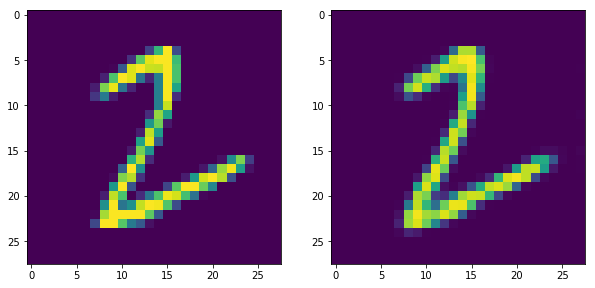

In [0]:
img = test_set[randint(1, 100)]
rec_img, _, _ = model2(img[0].unsqueeze(0).cuda(), one_hot_embedding(img[1], n_classes).unsqueeze(0).cuda())

fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(img[0].cpu().squeeze(0).squeeze(0).detach().numpy())
fig.add_subplot(rows, columns, 2)
plt.imshow(rec_img.cpu().squeeze(0).squeeze(0).detach().numpy())

plt.show()

#save_image(compare_x.data.cpu(), 'sample_image.png')
#display(Image('sample_image.png', width=700, unconfined=True))

##Generate image

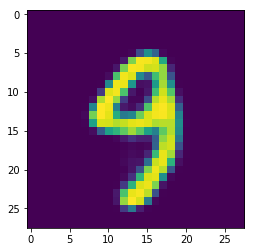

In [0]:
digit = 9
rec_img = model.decode(torch.randn(1, 16).cuda(), one_hot_embedding(digit, n_classes).unsqueeze(0).cuda())
plt.imshow(rec_img.cpu().squeeze(0).squeeze(0).detach().numpy())